# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [28]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
from sklearn.linear_model import LinearRegression
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv("./data/unconv.csv")
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

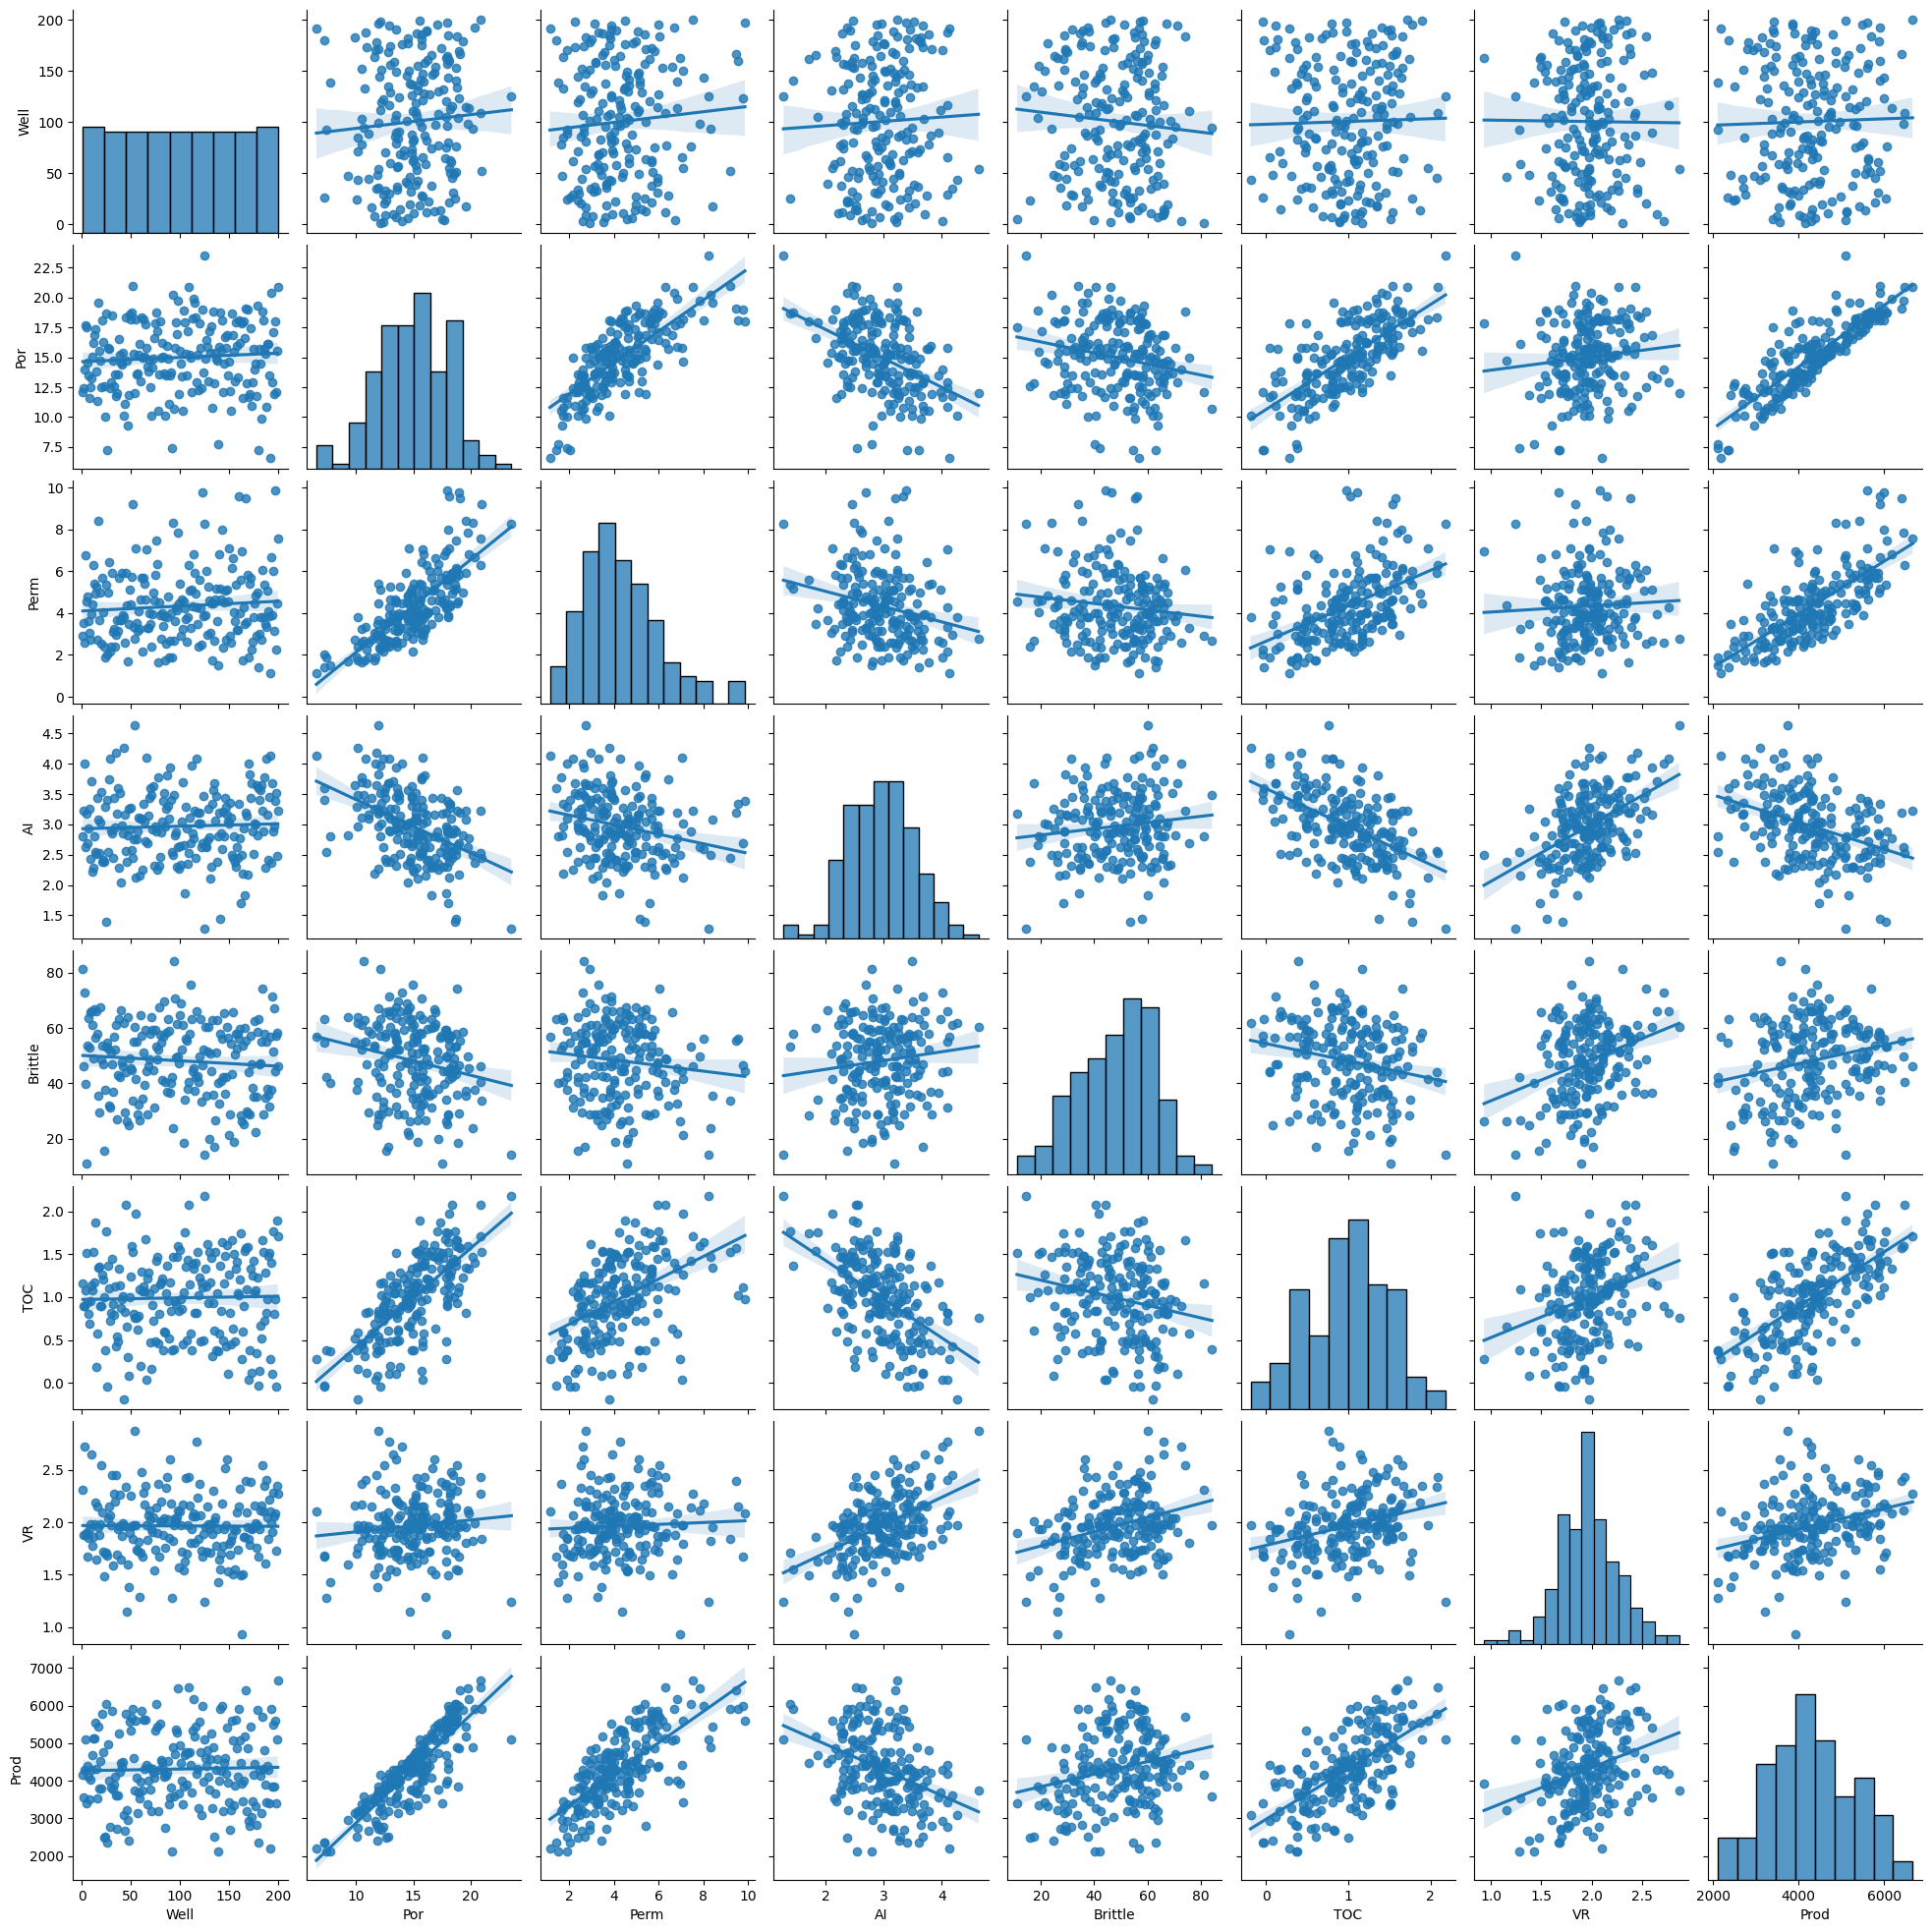

In [3]:
# Ваш код здесь
# Посмотрим на совместное распределение и дисперсию в данных
sns.pairplot(data, kind="reg")

> Как можно видеть большая шасть фитов распределенно близко к нормальному (кроме Well у него равномерное)

> Большая часть признаков при попарном разбросе имеют значительную дисперсию и следовательно низкую связь (лучше будеи видно на хитмапе)

In [4]:
# Проверим на наличие дубликатов и пропусков
dup = data.duplicated().sum()
nans = data.isna().sum()

print(f"Количество дубликатов в датасете: {dup}")
print("Пропуски в значениях:")
display(nans)

Количество дубликатов в датасете: 0
Пропуски в значениях:


Well       0
Por        0
Perm       0
AI         0
Brittle    0
TOC        0
VR         0
Prod       0
dtype: int64

> Пропусков нет, дубликатов нет

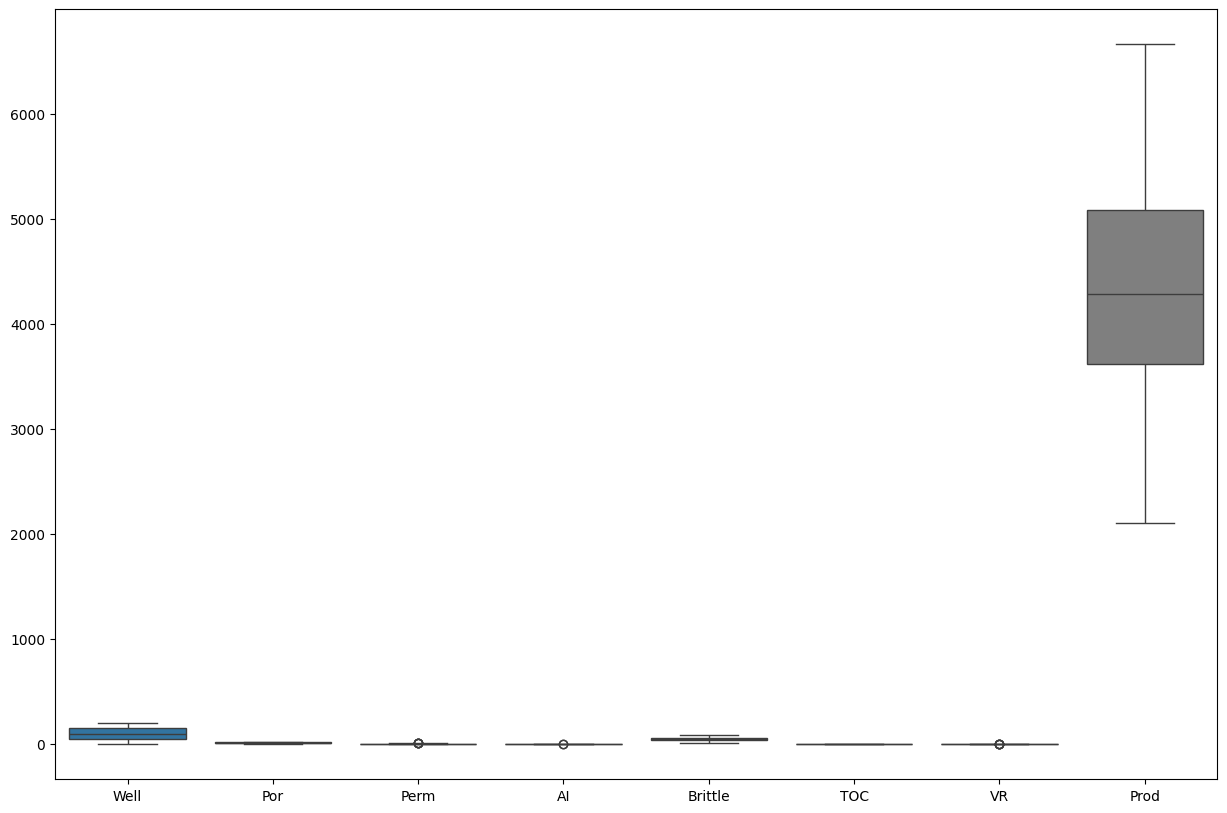

In [5]:
# Приближенно оценим наличие выбросов или аномалий
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

box = sns.boxplot(data=data, ax=ax)

> Выбросов и аномалий нет.

---

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

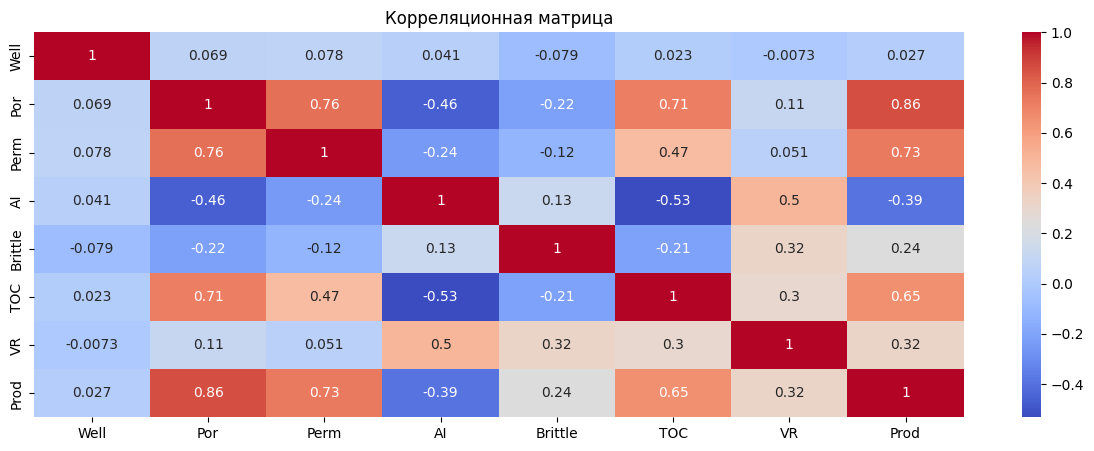

Ранг матрицы: 8, форма: (200, 8), определитель: 0.0007299388072652082


In [6]:
# Расчитаем матрицу корреляций
corr_mat = data.corr()

# Посчитаем ранг матрицы и определитель
rank = np.linalg.matrix_rank(corr_mat)
determinant = np.linalg.det(corr_mat)

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
corr = sns.heatmap(
    data=corr_mat,
    annot=True,
    cmap="coolwarm",
    ax=axes,
)

plt.title("Корреляционная матрица")
plt.show()

print(f"Ранг матрицы: {rank}, форма: {data.shape}, определитель: {determinant}")

> Наибольшее влияние на целевую переменную (Prod) оказывают следующие факторы:
* Por (0.86)
* Perm (0.73)
* TOC (0.65)

> Вероятная мультиколлинеарность:
* Por - Perm (0.76)
* Por - TOC (0.71)
> Возможно разумным будет использовать PCA для выделения информации из фитов, без удаления (например Por-TOC), так как высоко влияние на целевую переменную.

> Ранг матрицы равен количеству столбцов (фитов), что говорит о линейной независисости вектор-столбцов (фитов)

> Значение определителя блзко к нулю, что говорит о том, что матрица близка к сингулярной (вырожденной), т.е. плохо обусловленна.

> Метод наименьших квадратов может быть применен к плохо обусловленным матрицам, но при этом необходимо учитывать потенциальную неустойчивость результатов, так как возникают проблемы с обратной матрицей. В таких случаях могут помочь методы регуляризации (L1, L2, ElasticNet) при построении линейной регрессии.
---

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [7]:
# Ращобьем на матрицу наблюдений и таргета
X = data.drop(columns=["Prod"], axis=1)
y = data["Prod"]

# Добавим интерсепт
X = np.column_stack([np.ones(X.shape[0]), X])

# Расчитаем коэффициенты
coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
coefficients = np.round(coefficients)
# Вывод
columns = data.columns.to_list()[:-1]
columns.insert(0, "Interc")


result = pd.DataFrame(data=coefficients.reshape(1, -1), columns=columns)
display(result)

,Interc,Well,Por,Perm,AI,Brittle,TOC,VR
0,-1232.0,0.0,230.0,116.0,-365.0,25.0,-78.0,785.0


> Нулевое влияние показателя Well (следовательно кандидат на удаление)
 
>Высокий уровень показателя интерсепта в масштабах коэффициентов модели может говорить о недостаточности базовых коэффициентов для корректного прогноза, положительный знак при коэффициентах (Por, Perm, Brittle, VR) говорит о прямой связи и влиянии на таргет, т.е. увеличение отмеченных коэффициентов на 1 ед, приведет к увеличению таргета пропорционально коф. при переменной, и в противовес показатели (AI, TOC) имеют обратное влияние на таргет.

---

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [8]:
# Напишем функцию MAE и R^2 для последующей оценки
def mae_error(y_true, y_pred, round=3):
    """
    Вычисляет среднюю абсолютную ошибку (MAE) между истинными и предсказанными значениями.

    Args:
        y_true -- массив истинных значений
        y_pred -- массив предсказанных значений
        round -- количество знаков после запятой (по умолчанию 3)
    """

    # Вычисление средней абсолютной ошибки
    result = np.mean(np.abs(y_true - y_pred))

    # Округление до указанного количества знаков после запятой
    result = np.round(result, round)
    print(f"MAE: {result}")


def r2_score(y_true, y_pred, round=4):
    """
    Вычисляет коэффициент детерминации (R^2) для заданных истинных и предсказанных значений.

    Args:
        y_true -- массив истинных значений
        y_pred -- массив предсказанных значений
        round -- количество знаков после запятой (по умолчанию 4)
    """

    y_mean = np.mean(y_true)

    # Вычисление суммы квадратов отклонений истинных значений от их среднего
    ss_total = np.sum((y_true - y_mean) ** 2)
    # Вычисление суммы квадратов отклонений истинных значений от предсказанных
    ss_residual = np.sum((y_true - y_pred) ** 2)
    # Вычисление R^2
    r2 = 1 - (ss_residual / ss_total)
    # Округление до указанного количества знаков после запятой
    r2 = np.round(r2, round)
    print(f"R^2: {r2}")


################################

# Возьмем данные по новому объекту
new = {
    "Well": 106.0,
    "Por": 15.32,
    "Perm": 3.71,
    "AI": 3.29,
    "Brittle": 55.99,
    "TOC": 1.35,
    "VR": 2.42,
}
y_test = 4748.315024

# Вытащим значения и добавим свободный коэф.
X_new = np.array(list(new.values()))
X_new = np.insert(X_new, 0, 1)

# Используя расчитанные ранее коэф-ты (на этапе МНК) применим поэлементное умн-е
result = np.dot(X_new, coefficients)

mae_error(y_test, result)

MAE: 33.055


> В контексте таргета = 4748.315024, MAE = 33.055 - показывает, что в среднем прогнозируемые значения отклоняются от фактических на 33.055, что весьма точно.

In [9]:
# Проверка коэффициентов на первичном датасете и вывод ошибки
y_pred = np.dot(X, coefficients)
mae_error(y, y_pred)
r2_score(y, y_pred)
print(f"Среднее значение таргета: {np.mean(y)}")

MAE: 154.558
R^2: 0.9598
Среднее значение таргета: 4311.21985212


> (MAE) равна 154.558, говорит о том, что в среднем предсказание модели отклоняется от реальных по модулю на 154.558 (при среднем значении равным 4311.21985212, что достаточно точно). 

> Коэффициент детерминации (R^2) равный 0.9598, говорит о том, что модель достаточно точна и способна объяснить примерно 96% дисперсии зависимой переменной.

---

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [10]:
# Оформим коэффициенты корреляции в строку дф и присвоим индекс
corr_coef = data.corr()
corr_coef = corr_coef.iloc[-1, :-1]
corr_coef = corr_coef.values.reshape(1, -1)
corr_coef = np.insert(corr_coef, 0, 0)


corr_coef = pd.DataFrame(
    data=corr_coef.reshape(1, -1),
    columns=columns,
    index=["Корреляционные коэффициенты"],
)


# Оформим коэффициенты МНК в строку дф и присвоим индекс
lin_coef = pd.DataFrame(
    data=coefficients.reshape(1, -1), columns=columns, index=["Коэффициенты МНК"]
)


# Объединим коэффициенты МНК и корреляционные коэффициенты в одну таблицу и выведем её.
resulting_table = pd.concat([lin_coef, corr_coef], axis=0)
display(resulting_table)

,Interc,Well,Por,Perm,AI,Brittle,TOC,VR
Коэффициенты МНК,-1232.0,0.000000,230.00000,116.000000,-365.000000,25.000000,-78.000000,785.000000
Корреляционные коэффициенты,0.0,0.026817,0.86191,0.727426,-0.390835,0.237155,0.654445,0.323182


> В модели существует фактор (TOC), при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции. Коэффициент корреляции равный 0.65 говорит, что зависимость между фактором и целевой переменной прямая, но коэффициент при TOC найденый через МНК равен -78.0, что говорит об обратной связи. 

> Полученное противоречие результатов может быть связано с наличием мультиколлинеарности в модели, что было выявленно на этапе анализа тепловой карты (одна из точек подозрения на мультиколлинеарность была POR-TOC). Мультиколлинеарность может привести к необычным или неправильным оценкам коэффициентов регрессии, что в свою очередь может привести к таким противоречивым результатам.

---

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

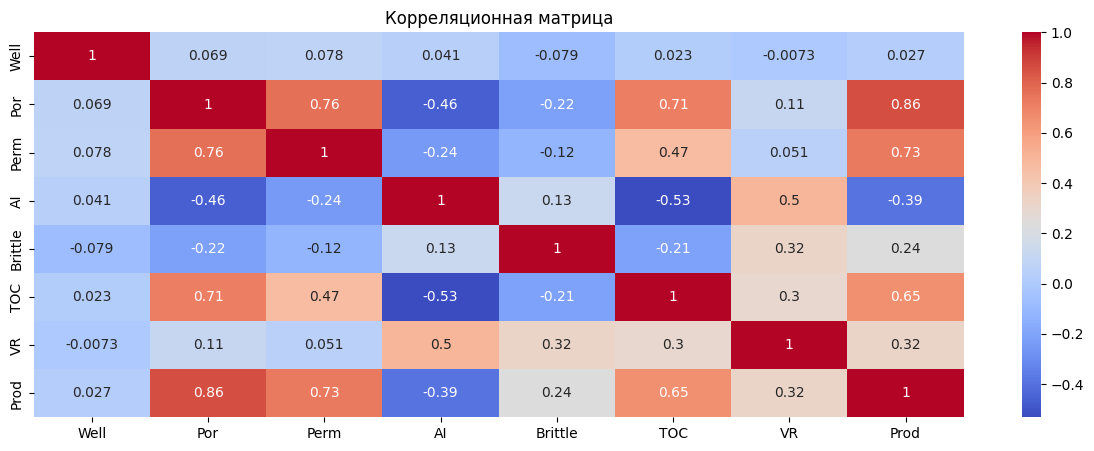

In [11]:
# Расчитаем матрицу корреляций и отобразим тепловую карту для наглядности
corr_mat = data.corr()

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
corr = sns.heatmap(
    data=corr_mat,
    annot=True,
    cmap="coolwarm",
    ax=axes,
)

plt.title("Корреляционная матрица")
plt.show()

> Убираем:
* TOC - вывод предыдущего этапа
* PERM - корреляция с Por, но меньше с таргетом (чем Por)
* Well - нулевой коэф-т при МНК

In [66]:
data_new = data.copy()

data_new.drop(columns=["TOC", "Perm", "Well"], axis=1, inplace=True)

columns_new = data_new.columns.to_list()[:-1]
columns_new.insert(0, "Interc")

X = data_new.drop(columns=["Prod"], axis=1)
y = data_new["Prod"]

# Добавим интерсепт
X = np.column_stack([np.ones(X.shape[0]), X])

# Расчитаем коэффициенты
coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
coefficients = coefficients


# Предскажем используя вектор весов
y_pred = np.dot(X, coefficients)

# Рассчитаем метрики MAE и R^2
mae = mae_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Выведем коэф-ты
lin_coef = np.round(coefficients).reshape(1, -1)

result_new = pd.DataFrame(
    data=lin_coef,
    columns=columns_new,
    index=["Коэффициенты МНК"],
)


corr_coef = data_new.corr()
corr_coef = corr_coef.iloc[-1, :-1]
corr_coef = corr_coef.values.reshape(1, -1)
corr_coef = np.insert(corr_coef, 0, 0).reshape(1, -1)


corr_coef = pd.DataFrame(
    data=corr_coef,
    columns=columns_new,
    index=["Корреляционные коэффициенты"],
)


# Объединим коэффициенты МНК и корреляционные коэффициенты в одну таблицу и выведем её.
resulting_table = pd.concat([result_new, corr_coef], axis=0)
display(resulting_table)

MAE: 171.431
R^2: 0.9452


,Interc,Por,AI,Brittle,VR
Коэффициенты МНК,-1835.0,293.00000,-200.000000,28.000000,517.000000
Корреляционные коэффициенты,0.0,0.86191,-0.390835,0.237155,0.323182


> Ухудшение метрики после удаления факторов с мультиколлинеарностью может указывать на потерю информации, которая была важна для объяснения целевой переменной (высокий уровень корреляции с таргетом). 

> Незначительно уменьшился коэф-т детерминации, более ощутимо ухудшилось MAE

> Использование метода главных компонент (PCA) могло бы быть более предпочтительным в данной ситуации, поскольку он позволяет учесть взаимосвязи между факторами и сохранить важную информацию при снижении размерности данных.

> Проблема разнонаправленности коэф-тов корреляции и регрессии устранена.

> Стоит учесть, что в прогнозе матрицы X выступали не округленные значения коэффициентов (заменчания для след. задания).

---

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [70]:
# Инициализируем объект класса
lr_model = LinearRegression(fit_intercept=False, n_jobs=-1)
# Обучим
lr_model.fit(X, y)

# Сформируем вектор предсказаний
y_pred_lr = lr_model.predict(X)

# Выведем коэффициенты
print(np.round(lr_model.coef_))

# Выведем метрики
mae_error(y, y_pred_lr)
r2_score(y, y_pred_lr)

[-1835.   293.  -200.    28.   517.]
MAE: 171.431
R^2: 0.9452


> Как можно наблюдать, метрики МНК и линейной регрессии (которая также реализованна через МНК sic!) сходятся.

> Коэф-ты также идентичны.

> В обоих случаях коэффициент детерминации весьма высок, описано более 94% дисперсии, при этом среднее абсолюьное отклонение укладывается в приятные нормы.

> Но опять же повторюсь, удаление скоррелировванного фита ухудшило метрику, что в итоге оказалось плохой стратегией.

> В первоначальном варианте, при прогнозировании вектора y_pred в методе МНК я использовал округленные значения коэф-тов, что дало не значительное отклонение метрик.

> Сходимость результатов ождаема

---

---

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [71]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [15]:
# Ваш код здесь

> *Ваши выводы здесь*

---

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [16]:
# Ваш код здесь

> *Ваши выводы здесь*

---

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [17]:
# Ваш код здесь

> *Ваши выводы здесь*

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

---

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [18]:
# Ваш код здесь

> *Ваши выводы здесь*

---

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [19]:
# Ваш код здесь

> *Ваши выводы здесь*